In [1]:
import numpy as np
from keras.layers import Input, Dense, Conv1D, AvgPool1D, MaxPool1D, Flatten, UpSampling1D, Reshape, BatchNormalization, LSTM
from keras.models import Model
from keras import regularizers
from keras.utils import to_categorical, print_summary
from keras.callbacks import CSVLogger
from sklearn.cluster import KMeans
from datasources import LoadMachineMonitoringData
from matplotlib import pyplot as plt

n_clusters = 5
n_features = 10

Using TensorFlow backend.


In [2]:
train, test, validate, meta = LoadMachineMonitoringData()

In [3]:
x_min = train.min(axis=(0, 1))
x_max = train.max(axis=(0, 1))
print('x_min.shape: {:}'.format(x_min.shape))
print('train.shape: {:}'.format(train.shape))
print('test.shape: {:}'.format(test.shape))
print('validate.shape: {:}'.format(validate.shape))
for channel_idx in range(x_min.size):
    train[:, :, channel_idx] = (train[:, :, channel_idx] - x_min[channel_idx]) / (x_max[channel_idx] - x_min[channel_idx])
    test[:, :, channel_idx] = (test[:, :, channel_idx] - x_min[channel_idx]) / (x_max[channel_idx] - x_min[channel_idx])
    validate[:, :, channel_idx] = (validate[:, :, channel_idx] - x_min[channel_idx]) / (x_max[channel_idx] - x_min[channel_idx])
print('train.shape: {:}'.format(train.shape))
print('test.shape: {:}'.format(test.shape))
print('validate.shape: {:}'.format(validate.shape))

x_min.shape: (17,)
train.shape: (1239, 6000, 17)
test.shape: (414, 6000, 17)
validate.shape: (552, 6000, 17)
train.shape: (1239, 6000, 17)
test.shape: (414, 6000, 17)
validate.shape: (552, 6000, 17)


In [26]:
kernel_l1 = 0
kernel_l2 = 1e-4
bias_l1 = 0
bias_l2 = 0
activation_l1 = 0
activation_l2 = 0

In [5]:
from keras import backend as K
def mean_squared_residual(y_true, y_pred):
    return K.mean(K.square((y_pred - y_true) / (K.abs(y_true) + 1)), axis=-2)

In [27]:
EncoderInputs = Input(shape=(train.shape[1], train.shape[2],))

RegularizerParams = {
    'kernel_regularizer': regularizers.l1_l2(kernel_l1, kernel_l2),
    'bias_regularizer': regularizers.l1_l2(bias_l1, bias_l2)
}

HiddenLayerParams = {
    'activation': 'relu',
    **RegularizerParams,
    'activity_regularizer': regularizers.l1_l2(activation_l1, activation_l2)
}

OutputLayerParams = {
    'activation': 'relu',
    **RegularizerParams
}

EncoderOutput = EncoderInputs
EncoderOutput = Flatten()(EncoderOutput)
EncoderOutput = Dense(n_features, **HiddenLayerParams, )(EncoderOutput)

EncoderModel = Model(inputs=EncoderInputs, outputs=EncoderOutput)
EncoderModel.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)
print_summary(EncoderModel)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 6000, 17)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 102000)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1020010   
Total params: 1,020,010
Trainable params: 1,020,010
Non-trainable params: 0
_________________________________________________________________


In [40]:
DenseLayerNeurons = EncoderModel.layers[-2].output_shape[1] // 10
OutputLayerShape = (EncoderModel.layers[-3].output_shape[1] // 10, EncoderModel.layers[-3].output_shape[2])
AutoEncoderOutput = Dense(DenseLayerNeurons, **OutputLayerParams)(EncoderOutput)
AutoEncoderOutput = Reshape(OutputLayerShape)(AutoEncoderOutput)
AutoEncoderOutput = UpSampling1D(size=10)(AutoEncoderOutput)

AutoEncoderModel = Model(inputs=EncoderInputs, outputs=AutoEncoderOutput)
AutoEncoderModel.compile(
    optimizer='adam',
    loss='mse',#mean_squared_residual,
    metrics=['mse']
)
print_summary(AutoEncoderModel)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 6000, 17)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 102000)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1020010   
_________________________________________________________________
dense_13 (Dense)             (None, 10200)             112200    
_________________________________________________________________
reshape_8 (Reshape)          (None, 600, 17)           0         
_________________________________________________________________
up_sampling1d_3 (UpSampling1 (None, 6000, 17)          0         
Total params: 1,132,210
Trainable params: 1,132,210
Non-trainable params: 0
_________________________________________________________________


In [41]:
ColOffset = (train.shape[1] - AutoEncoderModel.layers[-1].output_shape[1]) // 2
if ColOffset > 0:
    train_y = train[:, ColOffset:-ColOffset, :]
    test_y = test[:, ColOffset:-ColOffset, :]
    validate_y = validate[:, ColOffset:-ColOffset, :]
else:
    train_y = train
    test_y = test
    validate_y = validate
print(train_y.shape)
print(test_y.shape)
print(validate_y.shape)

(1239, 6000, 17)
(414, 6000, 17)
(552, 6000, 17)


In [42]:
log_file_name = 'l1={:}_l2={:}_dense-act={:}_output-act={:}_features={:}_log.csv'.format(kernel_l1, kernel_l2, HiddenLayerParams['activation'], OutputLayerParams['activation'], n_features)
csv_logger = CSVLogger(log_file_name, append=False, separator=',')

In [43]:
AutoEncoderModel.fit(train, train_y, validation_data=(test, test_y), batch_size=64, epochs=200, callbacks=[csv_logger])

Train on 1239 samples, validate on 414 samples
Epoch 1/200
1239/1239 [==============================] - 57s 46ms/step - loss: 0.3583 - mean_squared_error: 0.3560 - val_loss: 0.2734 - val_mean_squared_error: 0.2708
Epoch 2/200
1239/1239 [==============================] - 2s 1ms/step - loss: 0.2714 - mean_squared_error: 0.2688 - val_loss: 0.2694 - val_mean_squared_error: 0.2667
Epoch 3/200
1239/1239 [==============================] - 2s 1ms/step - loss: 0.2674 - mean_squared_error: 0.2648 - val_loss: 0.2653 - val_mean_squared_error: 0.2628
Epoch 4/200
1239/1239 [==============================] - 2s 1ms/step - loss: 0.2634 - mean_squared_error: 0.2610 - val_loss: 0.2615 - val_mean_squared_error: 0.2592
Epoch 5/200
1239/1239 [==============================] - 2s 1ms/step - loss: 0.2597 - mean_squared_error: 0.2576 - val_loss: 0.2580 - val_mean_squared_error: 0.2559
Epoch 6/200
1239/1239 [==============================] - 2s 2ms/step - loss: 0.2563 - mean_squared_error: 0.2544 - val_loss: 0

1239/1239 [==============================] - 2s 1ms/step - loss: 0.1761 - mean_squared_error: 0.1760 - val_loss: 0.1717 - val_mean_squared_error: 0.1716
Epoch 100/200
1239/1239 [==============================] - 2s 1ms/step - loss: 0.1723 - mean_squared_error: 0.1723 - val_loss: 0.1682 - val_mean_squared_error: 0.1681
Epoch 101/200
1239/1239 [==============================] - 2s 1ms/step - loss: 0.1687 - mean_squared_error: 0.1686 - val_loss: 0.1655 - val_mean_squared_error: 0.1654
Epoch 102/200
1239/1239 [==============================] - 2s 1ms/step - loss: 0.1660 - mean_squared_error: 0.1659 - val_loss: 0.1634 - val_mean_squared_error: 0.1633
Epoch 103/200
1239/1239 [==============================] - 2s 1ms/step - loss: 0.1638 - mean_squared_error: 0.1638 - val_loss: 0.1618 - val_mean_squared_error: 0.1617
Epoch 104/200
1239/1239 [==============================] - 2s 1ms/step - loss: 0.1621 - mean_squared_error: 0.1621 - val_loss: 0.1605 - val_mean_squared_error: 0.1605
Epoch 105/20

1239/1239 [==============================] - 2s 1ms/step - loss: 0.1532 - mean_squared_error: 0.1531 - val_loss: 0.1536 - val_mean_squared_error: 0.1536
Epoch 198/200
1239/1239 [==============================] - 2s 1ms/step - loss: 0.1513 - mean_squared_error: 0.1513 - val_loss: 0.1482 - val_mean_squared_error: 0.1481
Epoch 199/200
1239/1239 [==============================] - 2s 1ms/step - loss: 0.1460 - mean_squared_error: 0.1460 - val_loss: 0.1449 - val_mean_squared_error: 0.1448
Epoch 200/200
1239/1239 [==============================] - 2s 1ms/step - loss: 0.1349 - mean_squared_error: 0.1348 - val_loss: 0.1185 - val_mean_squared_error: 0.1184


In [91]:
AutoEncoderModel.save('auto-encoder.h5')

In [44]:
pred_validation_y = AutoEncoderModel.predict(validate)
print('Validation MSE: {:}'.format(np.mean((validate_y - pred_validation_y) ** 2)))

Validation MSE: 0.11740359663963318


In [45]:
data = np.vstack([train, test, validate])
enc_data = EncoderModel.predict(data)
print(enc_data.shape)

(2205, 10)


In [46]:
reconstructed_data = AutoEncoderModel.predict(data)
print(reconstructed_data.shape)

(2205, 6000, 17)


In [76]:
clust = KMeans(n_clusters=n_clusters)

In [77]:
clust_ids = clust.fit_predict(enc_data)

In [78]:
clust_ids

array([1, 3, 0, ..., 4, 3, 3])

In [79]:
profile = np.loadtxt('ex1-data/profile.txt', delimiter='\t', dtype=np.float32)

In [80]:
profile

array([[  3., 100.,   0., 130.,   1.],
       [  3., 100.,   0., 130.,   1.],
       [  3., 100.,   0., 130.,   1.],
       ...,
       [100., 100.,   0.,  90.,   0.],
       [100., 100.,   0.,  90.,   0.],
       [100., 100.,   0.,  90.,   0.]], dtype=float32)

In [81]:
for clust_id in range(n_clusters):
    mask = clust_ids == clust_id
    print('Cluster {:}'.format(clust_id))
    for feature, description in zip(range(5), ['Cooler', 'Valve', 'Internal pump', 'Hydraulic acc.', 'Stable']):
        unique, counts = np.unique(profile[mask, feature], return_counts=True)
        unique_counts = ['{:}={:}'.format(u, c) for u, c in zip(unique, counts)]
        print('{:} - counts of unique values: {:}'.format(description, ','.join(unique_counts)))
    print()

Cluster 0
Cooler - counts of unique values: 3.0=251,20.0=241,100.0=247
Valve - counts of unique values: 73.0=125,80.0=135,90.0=123,100.0=356
Internal pump - counts of unique values: 0.0=409,1.0=153,2.0=177
Hydraulic acc. - counts of unique values: 90.0=261,100.0=146,115.0=134,130.0=198
Stable - counts of unique values: 0.0=504,1.0=235

Cluster 1
Cooler - counts of unique values: 3.0=144,20.0=122,100.0=119
Valve - counts of unique values: 73.0=61,80.0=60,90.0=68,100.0=196
Internal pump - counts of unique values: 0.0=212,1.0=93,2.0=80
Hydraulic acc. - counts of unique values: 90.0=134,100.0=64,115.0=80,130.0=107
Stable - counts of unique values: 0.0=244,1.0=141

Cluster 2
Cooler - counts of unique values: 3.0=154,20.0=199,100.0=189
Valve - counts of unique values: 73.0=78,80.0=86,90.0=85,100.0=293
Internal pump - counts of unique values: 0.0=300,1.0=124,2.0=118
Hydraulic acc. - counts of unique values: 90.0=223,100.0=92,115.0=97,130.0=130
Stable - counts of unique values: 0.0=353,1.0=189

Cluster 0


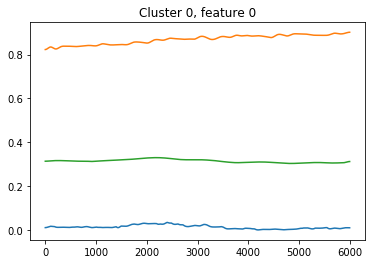

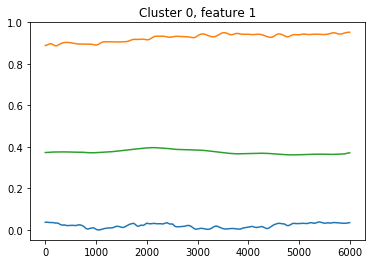

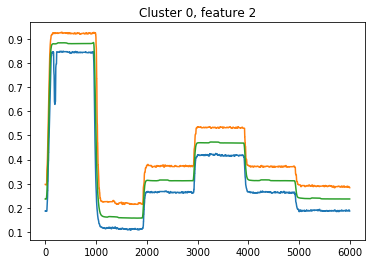

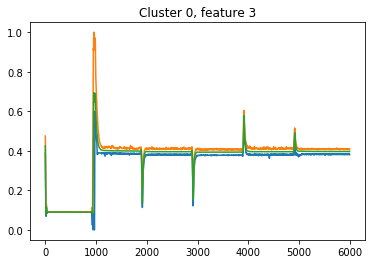

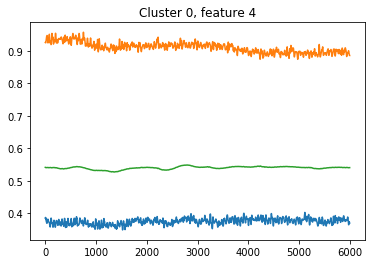

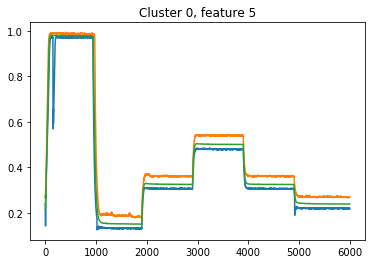

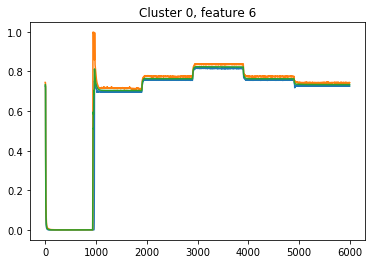

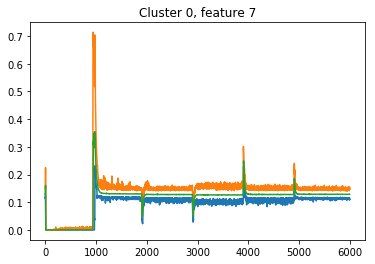

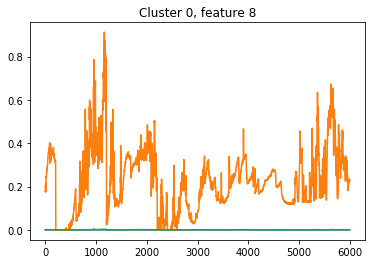

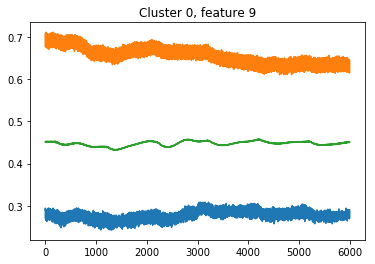

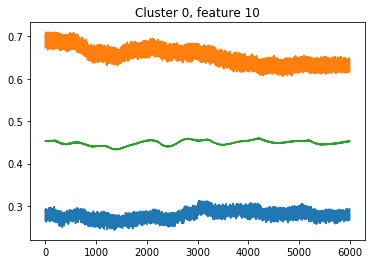

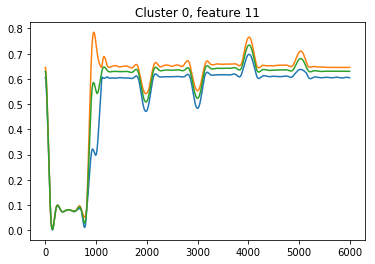

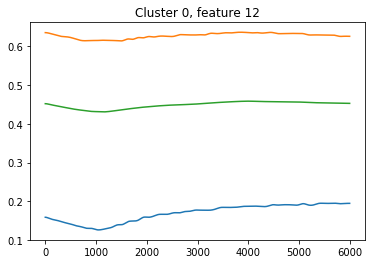

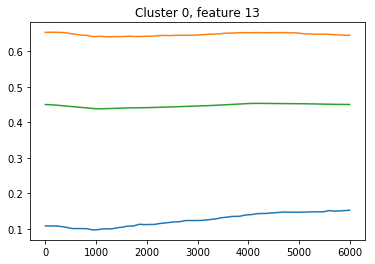

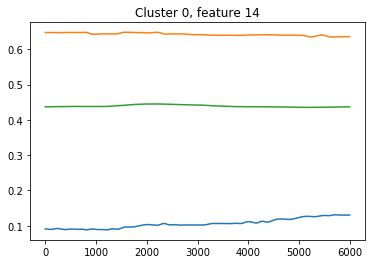

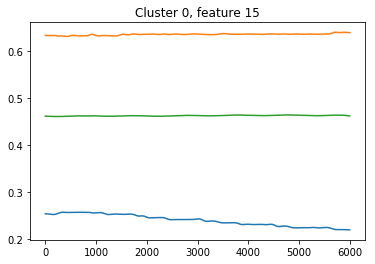

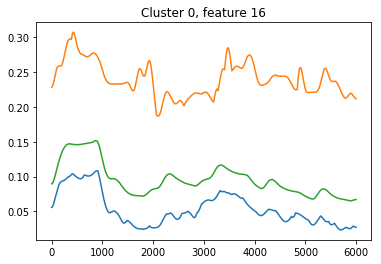

Cluster 1


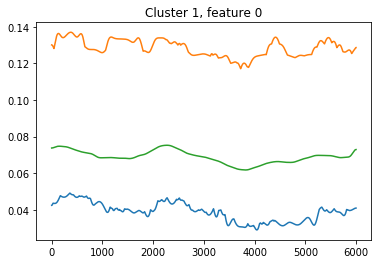

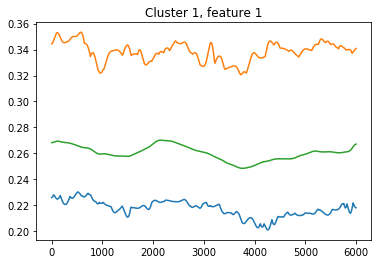

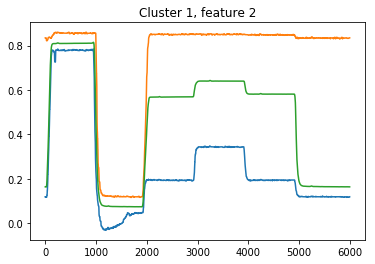

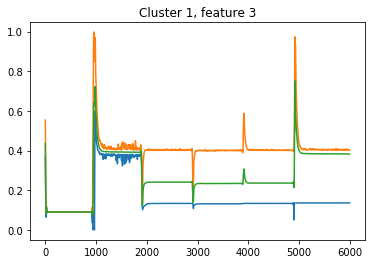

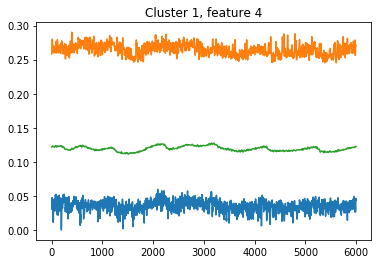

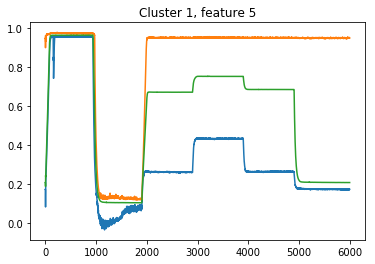

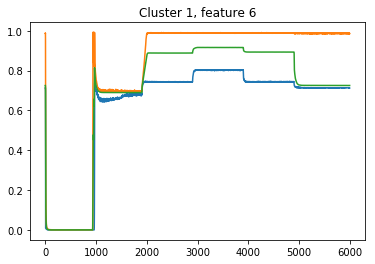

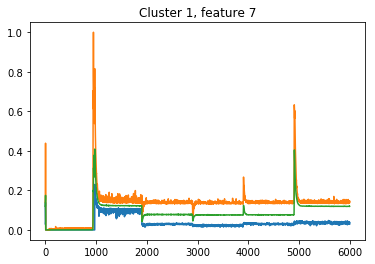

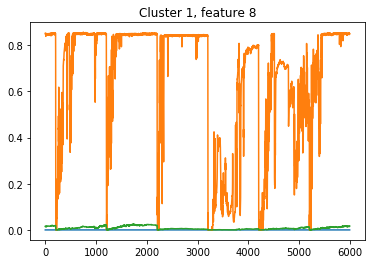

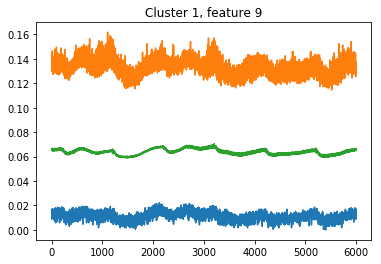

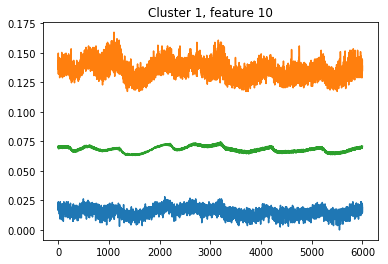

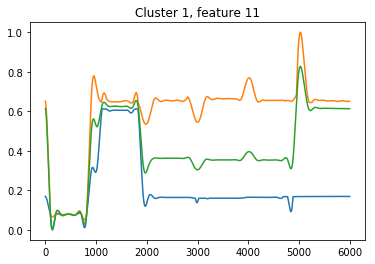

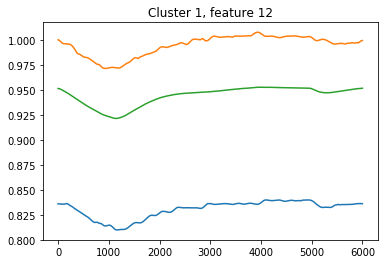

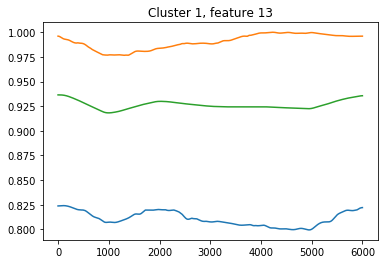

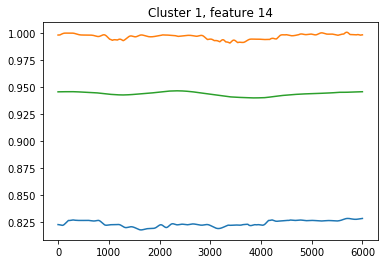

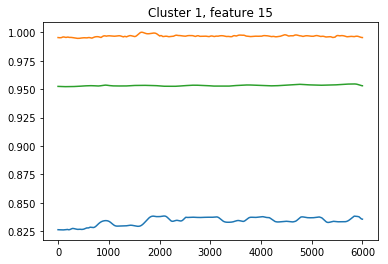

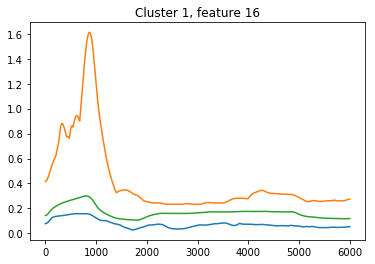

Cluster 2


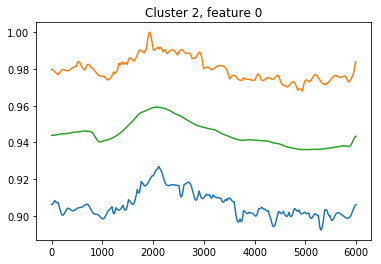

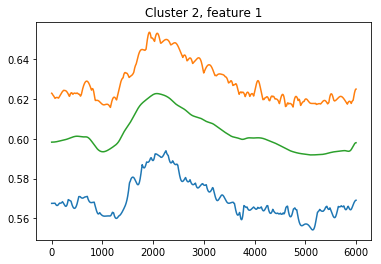

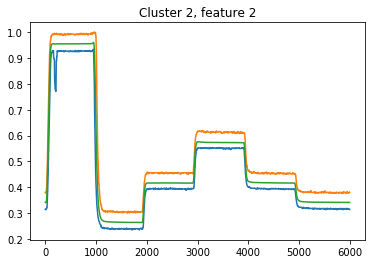

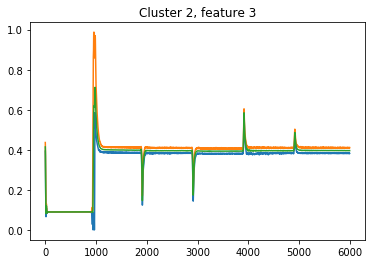

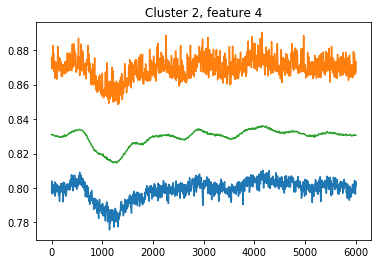

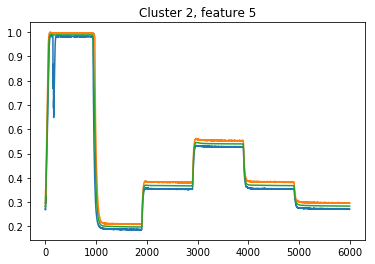

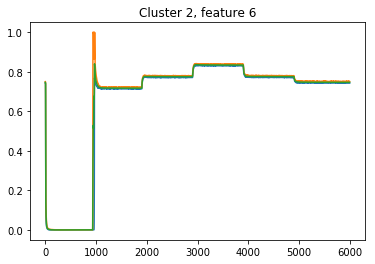

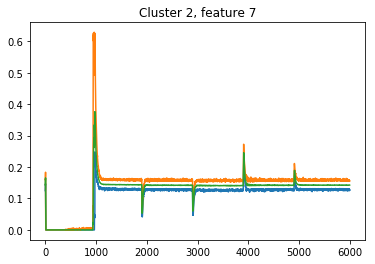

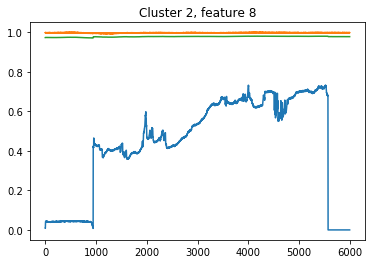

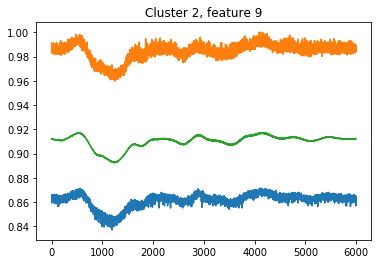

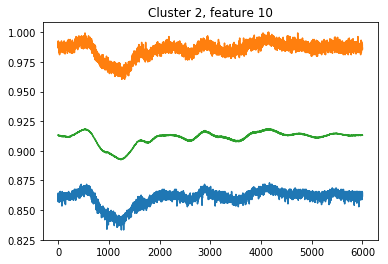

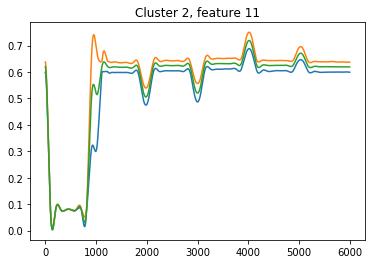

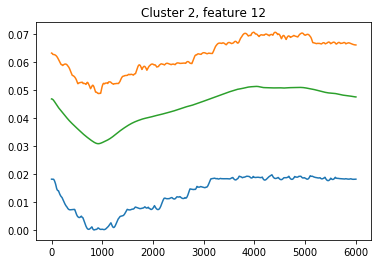

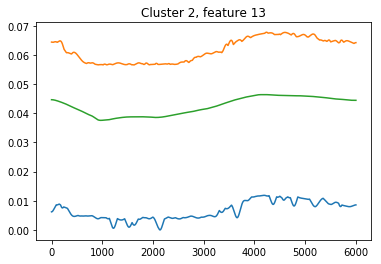

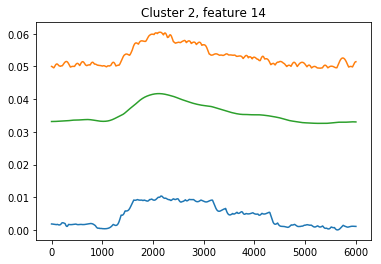

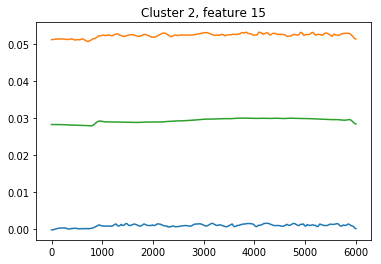

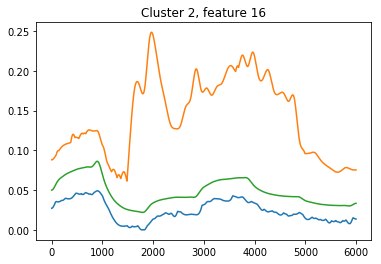

Cluster 3


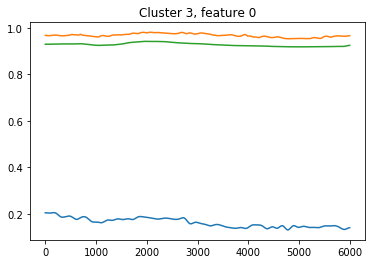

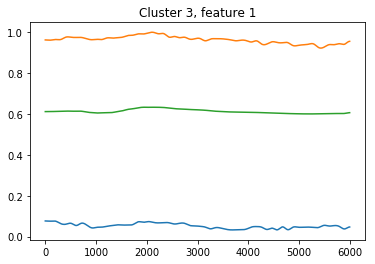

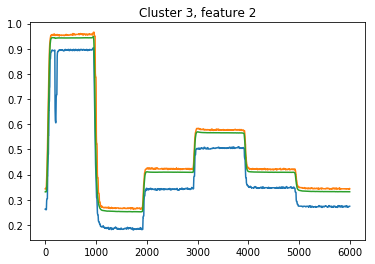

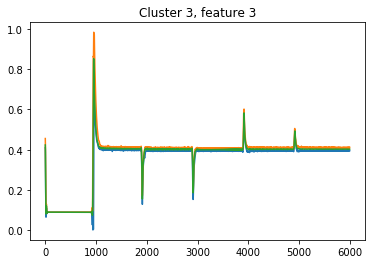

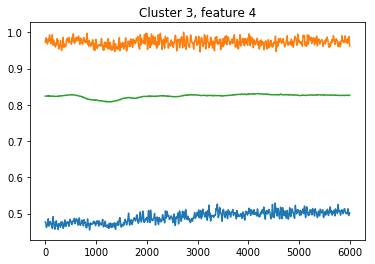

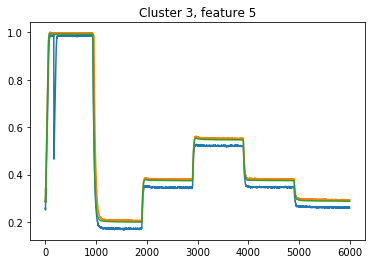

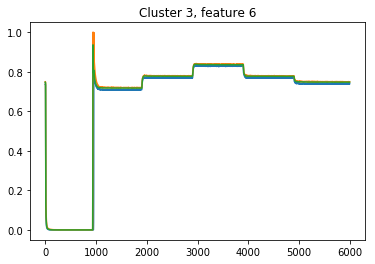

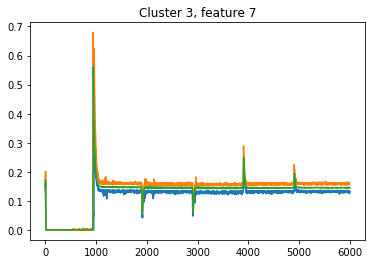

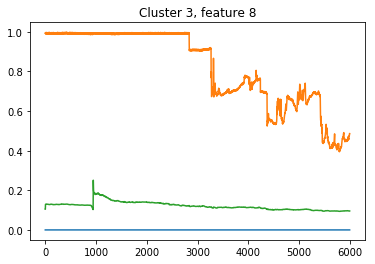

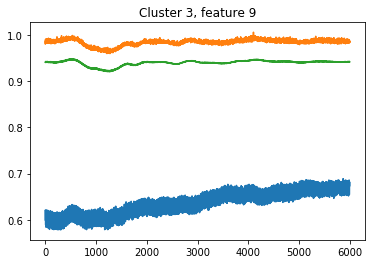

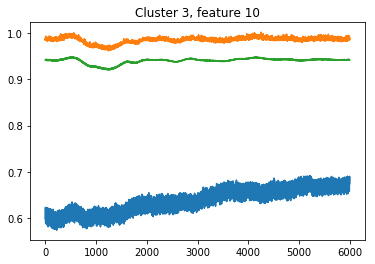

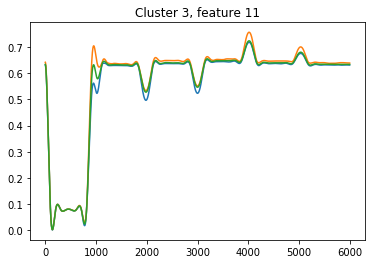

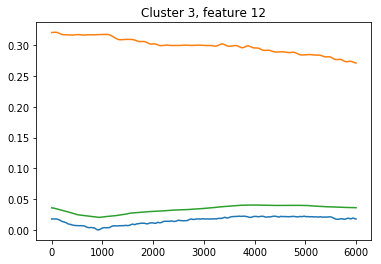

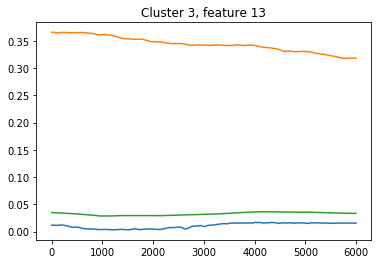

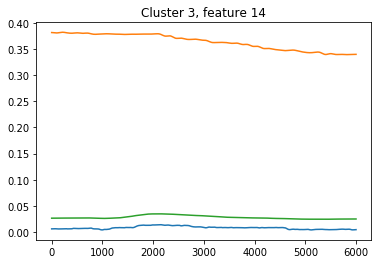

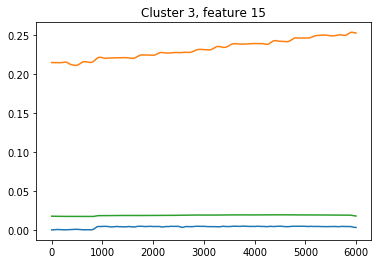

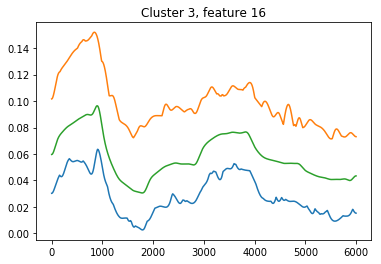

Cluster 4


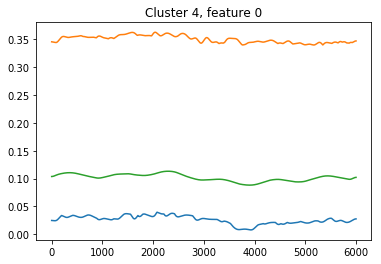

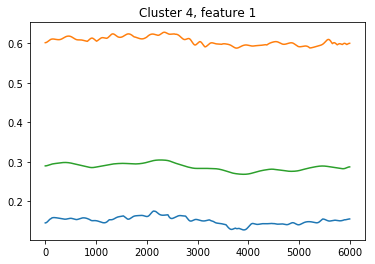

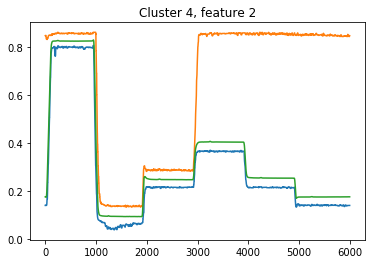

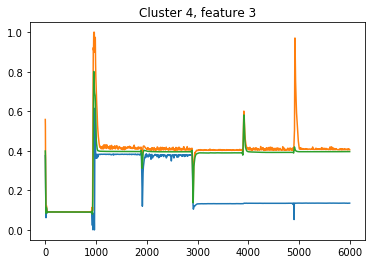

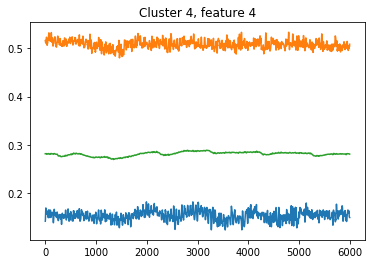

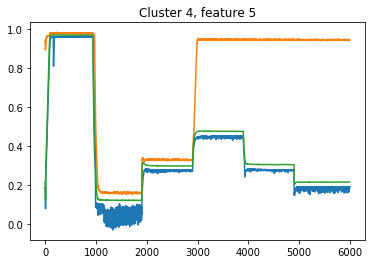

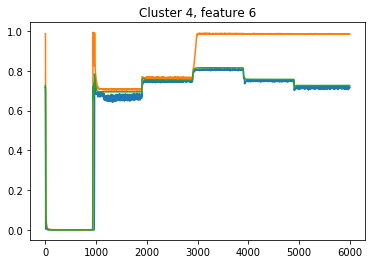

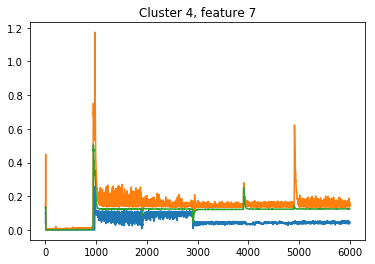

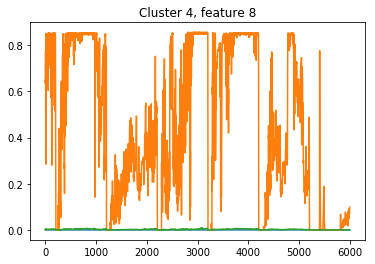

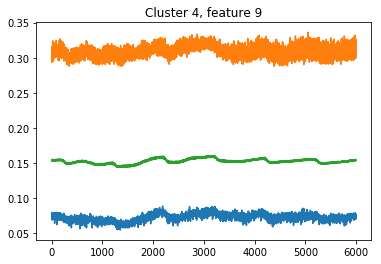

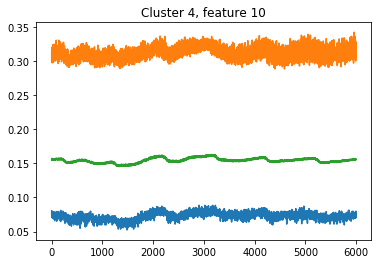

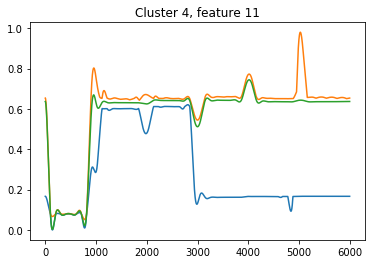

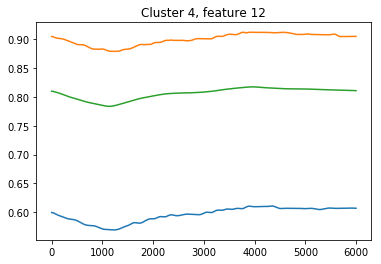

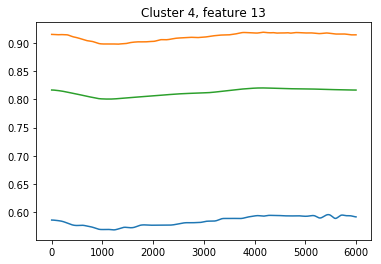

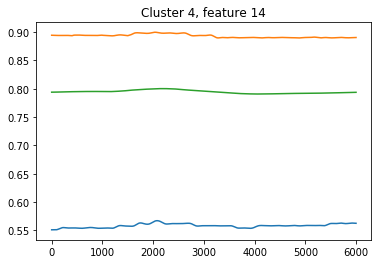

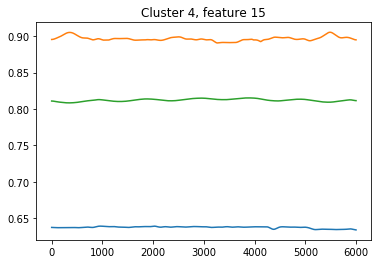

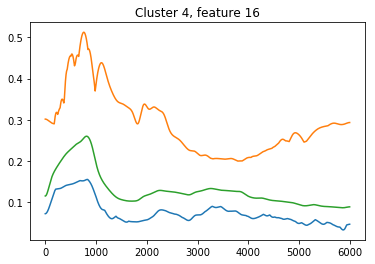

In [82]:
for clust_id in range(n_clusters):
    mask = clust_ids == clust_id
    print('Cluster {:}'.format(clust_id))
    for feature in range(data.shape[2]):
        min_trend = np.min(data[mask, :, feature], axis=0)
        max_trend = np.max(data[mask, :, feature], axis=0)
        mean_trend = np.mean(data[mask, :, feature], axis=0)

        plt.figure()
        x = np.arange(min_trend.shape[0])
        plt.plot(x, min_trend, x, max_trend, x, mean_trend)
        plt.title('Cluster {:}, feature {:}'.format(clust_id, feature))
        plt.show()

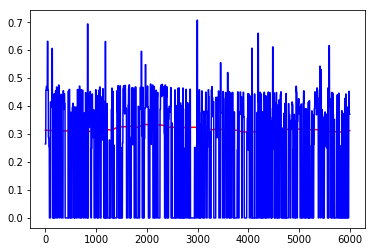

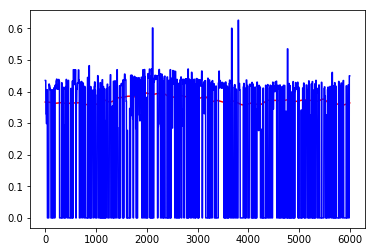

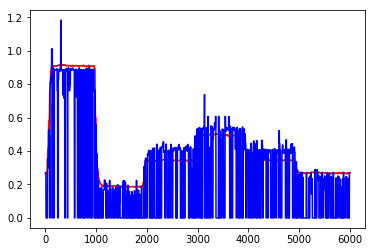

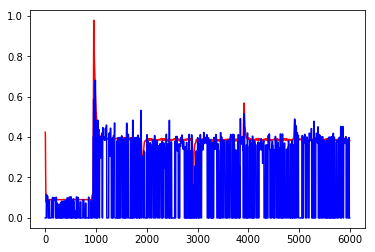

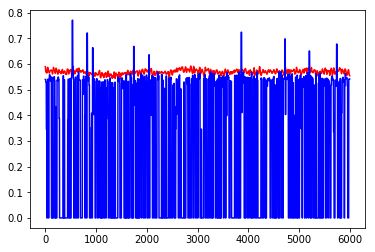

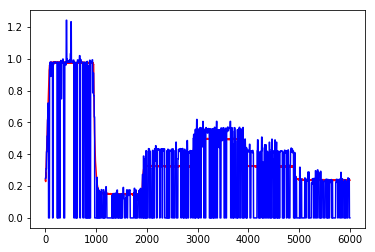

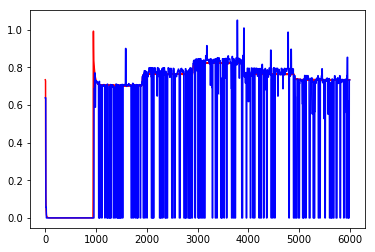

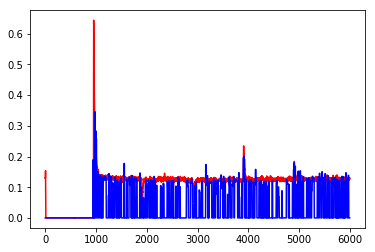

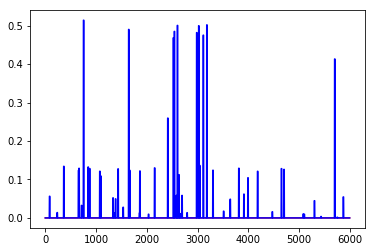

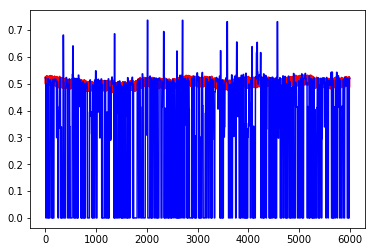

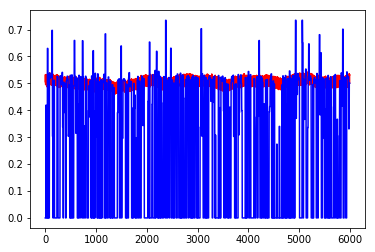

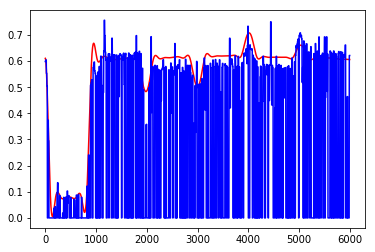

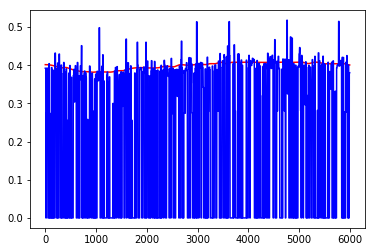

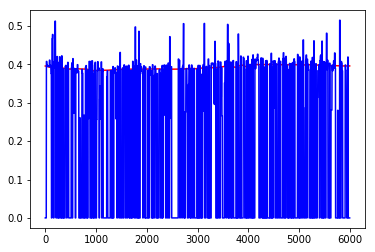

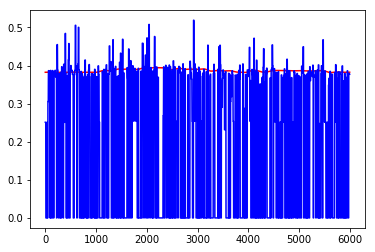

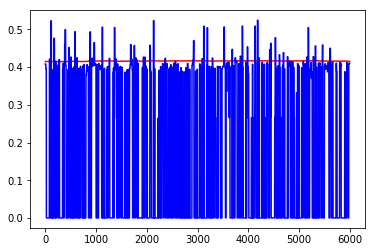

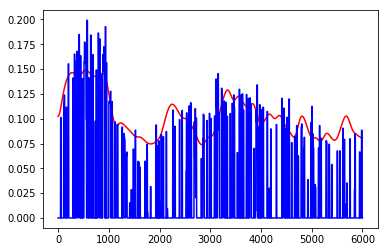

In [47]:
x_values = np.arange(data.shape[1])
x_values2 = np.arange(reconstructed_data.shape[1]) + (data.shape[1] - reconstructed_data.shape[1]) // 2
for idx in range(data.shape[2]):
    plt.figure()
    plt.plot(x_values, data[100, :, idx], 'r', x_values2, reconstructed_data[100, :, idx], 'b')
plt.show()